In [1]:
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import pymongo
import json 

In [2]:
# placeholder for API keys to pull data from debank (for additional context + mongoDB directly) 
debankAPI = ''
mongoAPI = ''

In [45]:
myclient = pymongo.MongoClient(mongoAPI)

mydb = myclient["65-1"]
collateral = mydb['accountcollaterals']
debt = mydb['accountdebts']

myquery = { "account": { "$regex": "^0" } }

tst = collateral.find(myquery) 
dfCollateral = pd.DataFrame(tst)
dfCollateral.to_csv("collateralRaw.csv")

tst = debt.find(myquery) 
dfDebt = pd.DataFrame(tst)
dfDebt.to_csv("debtRaw.csv")


In [46]:
import json 

insightUsers = accounts

headers = {'AccessKey': debankAPI}
base_url = 'https://pro-openapi.debank.com/v1'
total_balance = {}

for user in insightUsers:
    url = f'{base_url}/user/all_complex_protocol_list?id={user}'
    #print(url)
    res = requests.get(url, headers=headers)
    data = res.json()
    total_balance[user] = data
    #print(json.dumps(data, indent=4))

with open('./data.json', 'w') as f:
    json.dump(total_balance, f)
    
    
n = len(insightUsers)

cleanData = []

for user in insightUsers : 
    user_data = total_balance[user]
    address = user
    items = len(user_data)
    for j in range(items) : 
        item = user_data[j]
        
        portfolioInfo = item['portfolio_item_list']
        pItems = len(portfolioInfo)
        value = 0
        for p in range(pItems) : 
            value += item['portfolio_item_list'][p]['stats']['net_usd_value']
            #asset = 
        appendItem = {
            "User" : address,
            "Name" : item['name'],
            "Chain" : item['chain'],
            "Value" : value
        }
        
        cleanData.append(appendItem)
        
        
userDf = pd.DataFrame(cleanData)
userDf.to_csv("AAVEusers.csv")


In [47]:
dfCollateral = dfCollateral.sort_values(by='timestamp', ascending=False)
dfDebt = dfDebt.sort_values(by='timestamp', ascending=False)

In [48]:
startTime = min(dfDebt['timestamp'].min(), dfCollateral['timestamp'].min())
endTime = max(dfDebt['timestamp'].max(), dfCollateral['timestamp'].max())
accounts = dfCollateral['account'].unique()

collatTokens = dfCollateral['symbol'].unique()
debtTokens = dfDebt['symbol'].unique()



In [49]:
t = int( (endTime - startTime) / 3600)

In [50]:
def fillDebtData(token) : 

    time = []
    totalAmount = []
    totalAmountUSD = []
    totalUsers = []
    tokenList = []
    _time = startTime

    dfToken = dfDebt[dfDebt['symbol'] == token]
    for i in range(t) : 
        dfRed = dfToken[dfToken['timestamp'] < _time] 
        dfRed = dfRed.drop_duplicates(subset=['account'])
        time.append(_time)
        totalAmount.append(sum(dfRed['debtAmountTotal']))
        totalAmountUSD.append(sum(dfRed['debtAmountTotalUsd']))
        totalUsers.append(len(dfRed))
        _time += 3600 

    dfOut = pd.DataFrame({
        'token' : token, 
        'timeStamp' : time,
        'totalDebt' : totalAmount,
        'totalDebtUsd' : totalAmountUSD, 
        'totalUsers' : totalUsers}
    )
    dfOut['date'] = pd.to_datetime(dfOut['timeStamp'], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')
    return dfOut

In [51]:
debtTokens

array(['variableDebtEthDAI', 'variableDebtEthWETH', 'stableDebtEthDAI',
       'variableDebtEthUSDC', 'variableDebtEthUSDT', 'stableDebtEthUSDT',
       'stableDebtEthUSDC', 'variableDebtEthWBTC', 'variableDebtEthEURS',
       'variableDebtEthLINK', 'stableDebtEthEURS'], dtype=object)

In [52]:
dfOut = fillDebtData(debtTokens[0])

In [53]:
dfOut

,token,timeStamp,totalDebt,totalDebtUsd,totalUsers,date
0,variableDebtEthDAI,1677842664,0.000000,0.000000,0,2023-03-03 11:24:24
1,variableDebtEthDAI,1677846264,1300.663192,1300.663192,2,2023-03-03 12:24:24
2,variableDebtEthDAI,1677849864,1300.663192,1300.663192,2,2023-03-03 13:24:24
3,variableDebtEthDAI,1677853464,1300.663192,1300.663192,2,2023-03-03 14:24:24
4,variableDebtEthDAI,1677857064,1300.663192,1300.663192,2,2023-03-03 15:24:24
...,...,...,...,...,...,...
1031,variableDebtEthDAI,1681554264,458893.132586,458893.132586,219,2023-04-15 10:24:24
1032,variableDebtEthDAI,1681557864,458893.132586,458893.132586,219,2023-04-15 11:24:24
1033,variableDebtEthDAI,1681561464,458893.132586,458893.132586,219,2023-04-15 12:24:24
1034,variableDebtEthDAI,1681565064,458893.132586,458893.132586,219,2023-04-15 13:24:24


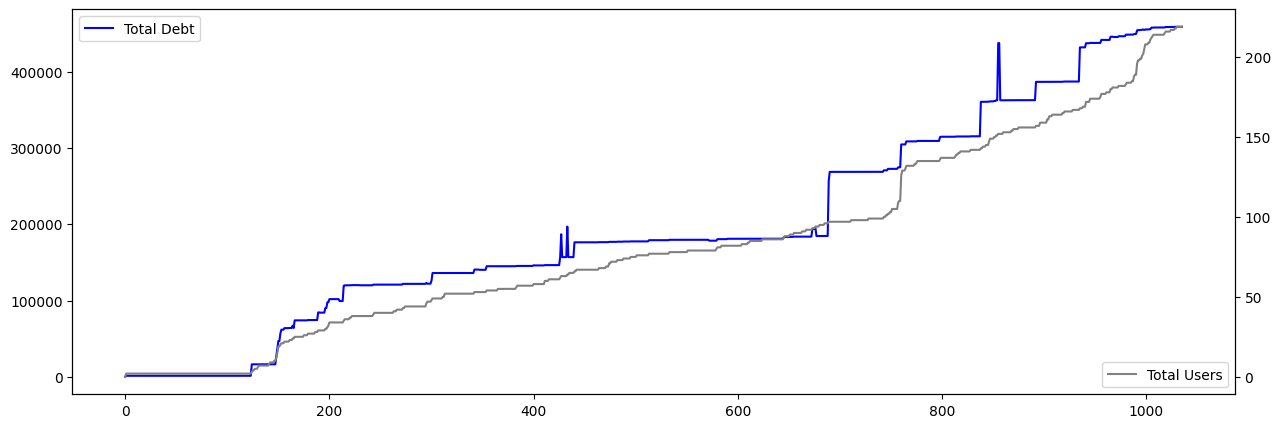

In [54]:
fig = plt.figure()
fig.set_size_inches(15,5)

#fig.subplots_adjust(hspace=1, wspace=1)

ax = fig.add_subplot(1, 1, 1)
ax.plot(dfOut['totalDebt'], color = 'blue', label = 'Total Debt' )
ax2 = ax.twinx()
ax2.plot(dfOut['totalUsers'], color = 'grey', label = 'Total Users' )

ax.legend(loc = 'upper left')
ax2.legend(loc = 'lower right')